# **Black Friday Sales Prediction**

A retail company wants to predict customer purchase amounts based on demographics and product details to create personalized offers. Using data on customer purchases, demographics, and product categories, they aim to build a model that accurately forecasts purchase behavior to optimize marketing strategies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/datasets/cerolacia/black-friday-sales-prediction
df=pd.read_csv("/content/train_blackfridaysale.csv")

In [ ]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [ ]:
df.shape

(550068, 12)

In [ ]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [ ]:
df = df.drop(["User_ID","Product_ID"],axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          376430 non-null  float64
 8   Product_Category_3          166821 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


**Handling Null Values**

In [ ]:
df.isnull().sum()

,0
Gender,0
Age,0
Occupation,0
City_Category,0
Stay_In_Current_City_Years,0
Marital_Status,0
Product_Category_1,0
Product_Category_2,173638
Product_Category_3,383247
Purchase,0


In [ ]:
df['Product_Category_2'] =df['Product_Category_2'].fillna(df["Product_Category_2"].mode()[0]).astype('int64')
df['Product_Category_3'] =df['Product_Category_3'].fillna(df["Product_Category_2"].mode()[0]).astype('int64')


In [ ]:
df.isnull().sum()

,0
Gender,0
Age,0
Occupation,0
City_Category,0
Stay_In_Current_City_Years,0
Marital_Status,0
Product_Category_1,0
Product_Category_2,0
Product_Category_3,0
Purchase,0


In [ ]:
# df.dropna(inplace=True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Occupation,550068.0,8.076707,6.522660,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,0.409653,0.491770,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,5.404270,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,550068.0,9.260768,4.294093,2.0,8.0,8.0,14.0,18.0
Product_Category_3,550068.0,9.415754,3.125051,3.0,8.0,8.0,8.0,18.0
Purchase,550068.0,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


# **EDA**

**Target Variable Purchase**

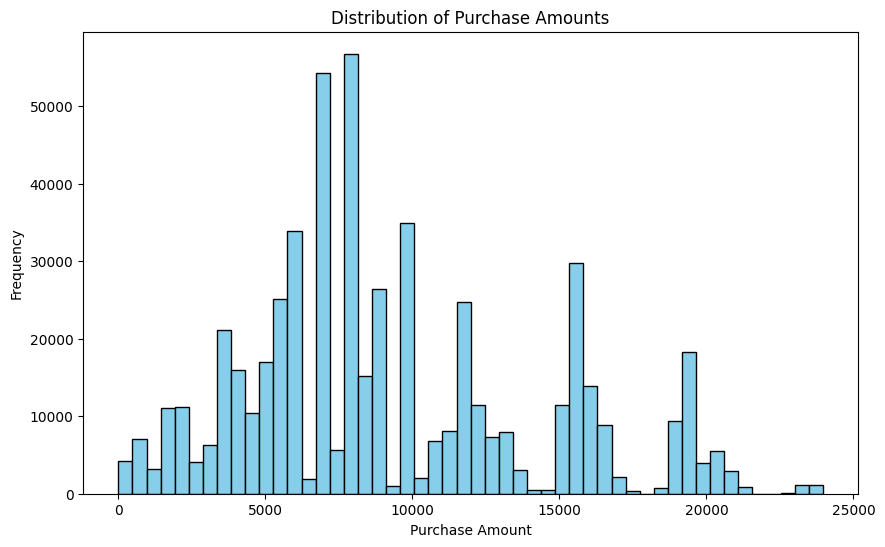

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(df['Purchase'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

<Axes: ylabel='Purchase'>

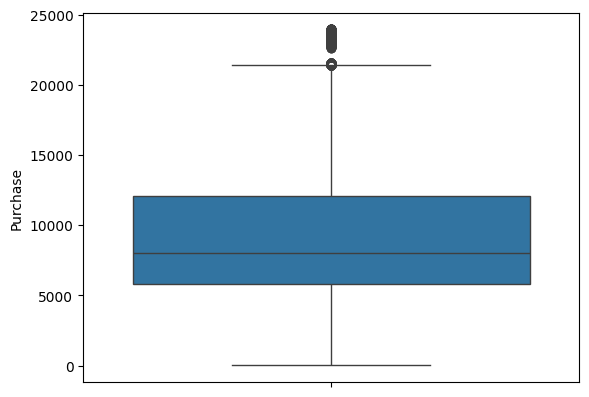

In [ ]:
sns.boxplot(df['Purchase'])

In [ ]:
q1 = df['Purchase'].quantile(0.25)
q3 = df['Purchase'].quantile(0.75)
iqr = q3 - q1
min_range = q1 - 1.5 * iqr
max_range = q3 + 1.5 * iqr
df = df[(df['Purchase'] > min_range) & (df['Purchase'] < max_range)]
df.reset_index(drop=True,inplace=True)

<Axes: ylabel='Purchase'>

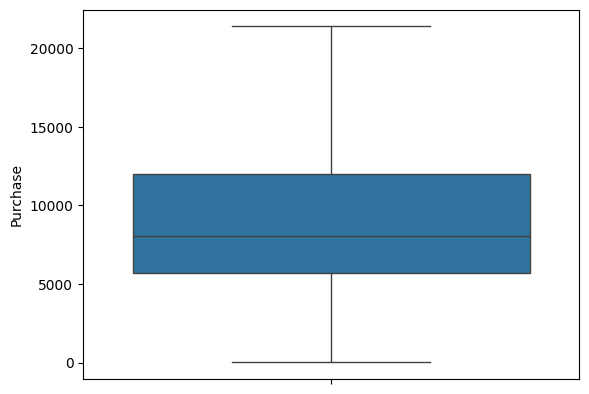

In [ ]:
sns.boxplot(df['Purchase'])

*Here,we observe that the purchase amounts are often repeated among many
customers. This pattern may be due to the fact that, on Black Friday, many customers purchase discounted products in large quantities, resulting in purchase amounts that tend to cluster around similar values, resembling a Gaussian distribution.*


---



**Gender**

In [ ]:
df['Gender'].value_counts()

,count
Gender,
M,412171
F,135220


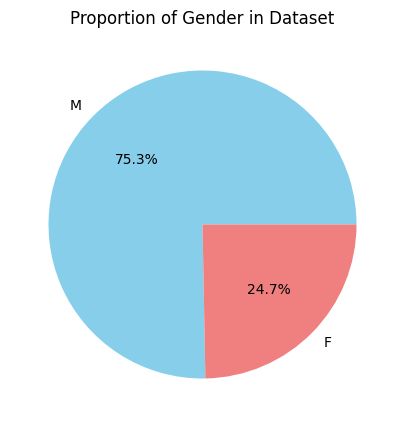

In [ ]:
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Gender in Dataset')
plt.show()

*The dataset shows a higher proportion of males compared to females, with males comprising 75.3% and females 24.7%.*

---



**Marital Status**

In [ ]:
df['Marital_Status'].value_counts()

,count
Marital_Status,
0,323242
1,224149


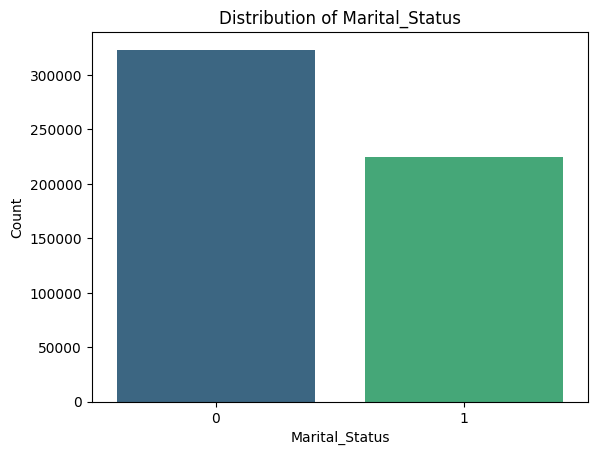

In [ ]:
sns.countplot(data = df , x='Marital_Status',palette='viridis')
plt.title('Distribution of Marital_Status')
plt.xlabel('Marital_Status')
plt.ylabel('Count')
plt.show()

In [ ]:
df.groupby("Marital_Status")["Purchase"].mean()

,Purchase
Marital_Status,
0,9201.581849
1,9187.040076


There are more unmarried individuals in the dataset who make more purchases. Interestingly, even though unmarried people buy more, the average purchase amount between married and unmarried individuals remains the same.


---





**Occupation**

In [ ]:
df['Occupation'].value_counts()

,count
Occupation,
4,72040
0,69310
7,58875
1,47174
17,39855
20,33355
12,30995
14,27173
2,26435


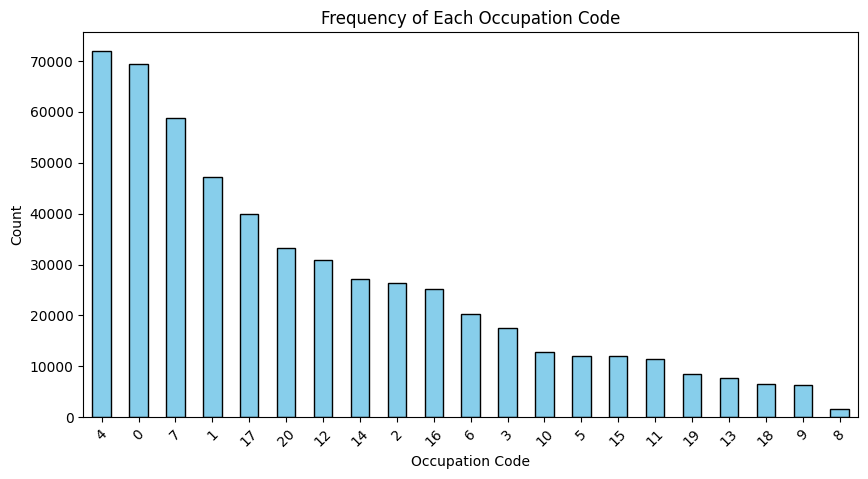

In [ ]:
# Count occurrences of each occupation code
occupation_counts = df['Occupation'].value_counts()

# Plot
plt.figure(figsize=(10, 5))
occupation_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Occupation Code')
plt.xlabel('Occupation Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

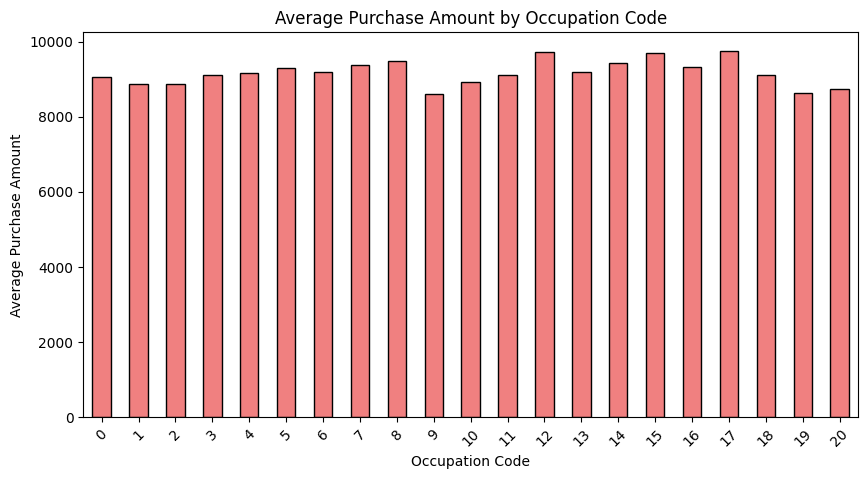

In [ ]:
# Calculate average purchase amount by occupation code
avg_purchase_by_occupation = df.groupby('Occupation')['Purchase'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_purchase_by_occupation.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Purchase Amount by Occupation Code')
plt.xlabel('Occupation Code')
plt.ylabel('Average Purchase Amount')
plt.xticks(rotation=45)
plt.show()

*The `Occupation` column contains at least 20 distinct values, and since we don't know which number corresponds to which occupation, analyzing this data is challenging. Despite this, we have to use the data as there’s no feasible way to reduce the number of categories. Although some occupations are more frequently represented, the average amount spent by users appears to be relatively consistent across different occupations. Naturally, occupations with higher frequencies will end up with higher total purchase amounts.*

---



**City_Category**

In [ ]:
df['City_Category'].value_counts()

,count
City_Category,
B,230114
C,170241
A,147036


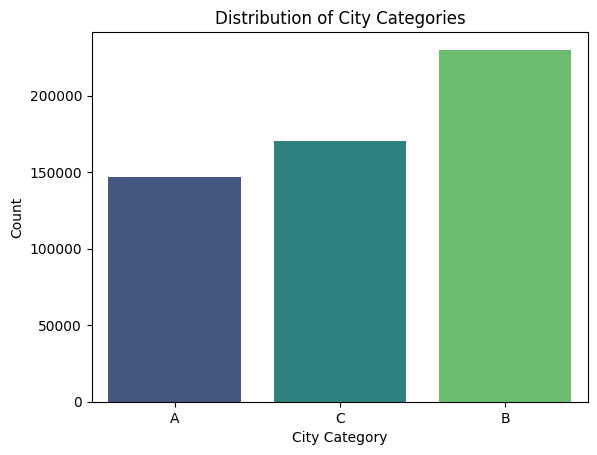

In [ ]:
sns.countplot(x='City_Category', data=df, palette='viridis')
plt.title('Distribution of City Categories')
plt.xlabel('City Category')
plt.ylabel('Count')
plt.show()

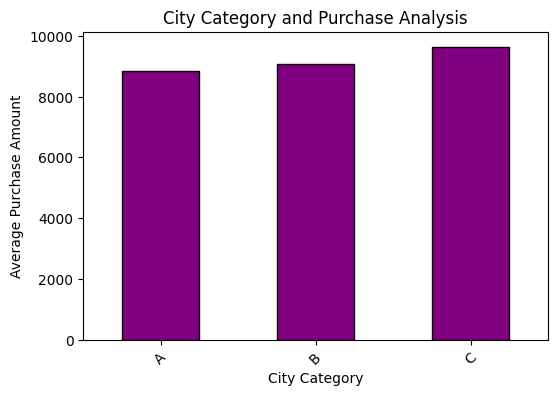

In [ ]:
# Calculate average purchase amount by City_Category
avg_purchase_by_City_Category = df.groupby('City_Category')['Purchase'].mean()

# Plot
plt.figure(figsize=(6, 4))
avg_purchase_by_City_Category.plot(kind='bar', color='purple', edgecolor='black')
plt.title('City Category and Purchase Analysis')
plt.xlabel('City Category')
plt.ylabel('Average Purchase Amount')
plt.xticks(rotation=45)
plt.show()


*It is observed that city category B has made the most number of puchases.However, the city whose buyers spend the most is city type C*

---





**Stay_In_Current_City_Years**

In [ ]:
df['Stay_In_Current_City_Years'].value_counts()

,count
Stay_In_Current_City_Years,
1,192845
2,101384
3,94804
4+,84322
0,74036


In [ ]:
# df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace(to_replace="4+",value="4")

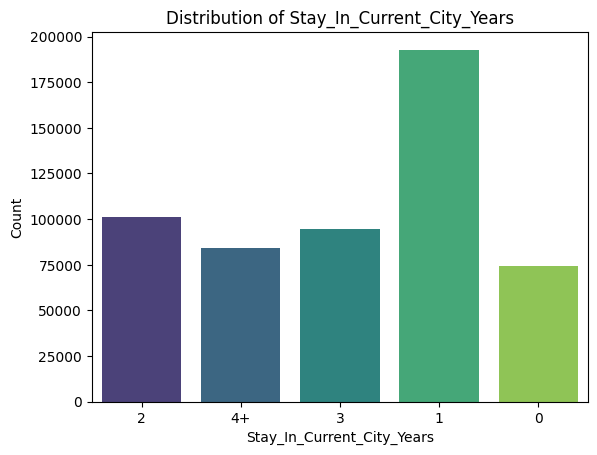

In [ ]:
sns.countplot(x='Stay_In_Current_City_Years', data=df, palette='viridis')
plt.title('Distribution of Stay_In_Current_City_Years')
plt.xlabel('Stay_In_Current_City_Years')
plt.ylabel('Count')
plt.show()

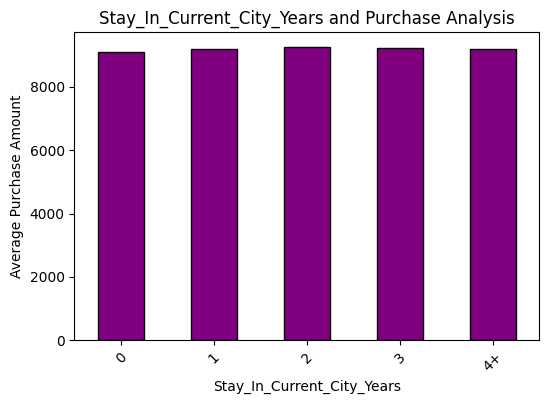

In [ ]:
avg_purchase_by_Stay_In_Current_City_Years = df.groupby('Stay_In_Current_City_Years')['Purchase'].mean()

# Plot
plt.figure(figsize=(6, 4))
avg_purchase_by_Stay_In_Current_City_Years.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Stay_In_Current_City_Years and Purchase Analysis')
plt.xlabel('Stay_In_Current_City_Years')
plt.ylabel('Average Purchase Amount')
plt.xticks(rotation=45)
plt.show()

*It seems that individuals who have lived in a city for a longer period are less likely to make new purchases. In contrast, newcomers to the city, who may need to buy many new items for their homes, are more likely to take advantage of Black Friday discounts. This trend reflects a pattern seen previously, where the average spending on purchases is consistent across different groups. Although newcomers account for a higher volume of purchases, the amount they spend on average does not vary significantly based on how long they have lived in the city.*

---



**Age**

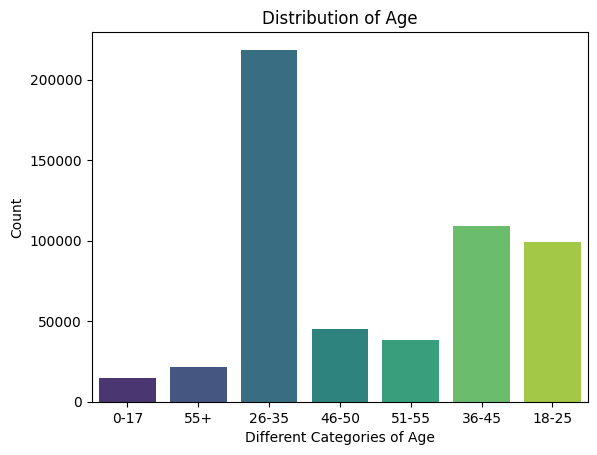

In [ ]:
sns.countplot(x='Age', data=df, palette='viridis')
plt.title('Distribution of Age')
plt.xlabel('Different Categories of Age')
plt.ylabel('Count')
plt.show()

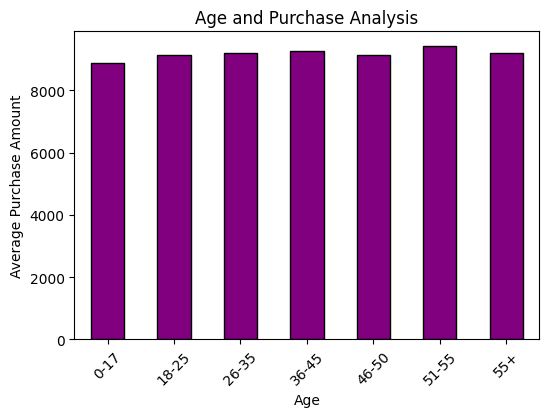

In [ ]:
avg_purchase_by_Age = df.groupby('Age')['Purchase'].mean()

# Plot
plt.figure(figsize=(6, 4))
avg_purchase_by_Age.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Age and Purchase Analysis')
plt.xlabel('Age')
plt.ylabel('Average Purchase Amount')
plt.xticks(rotation=45)
plt.show()

*The age group 26-35 makes the highest number of purchases compared to other age groups. While the mean purchase amounts are generally consistent across different age groups, the 51-55 age group has a slightly higher average purchase amount.*

---



**Product_Category_1**

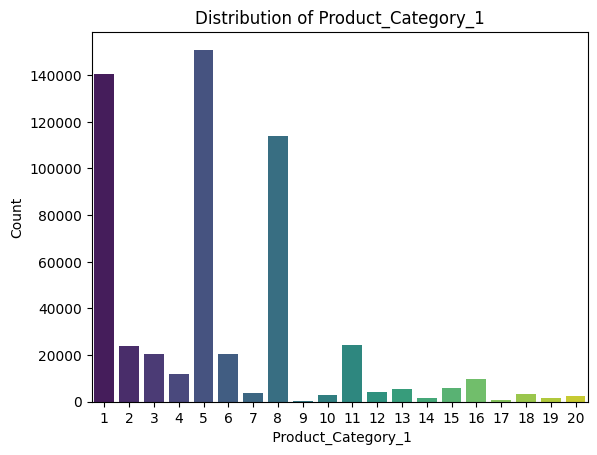

In [ ]:
sns.countplot(x='Product_Category_1', data=df, palette='viridis')
plt.title('Distribution of Product_Category_1')
plt.xlabel(' Product_Category_1')
plt.ylabel('Count')
plt.show()


**Product_Category_2**

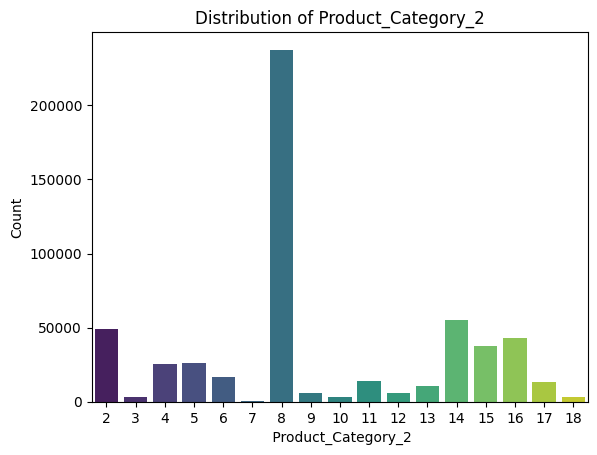

In [ ]:
sns.countplot(x='Product_Category_2', data=df, palette='viridis')
plt.title('Distribution of Product_Category_2')
plt.xlabel(' Product_Category_2')
plt.ylabel('Count')
plt.show()

**Product_Category_3**

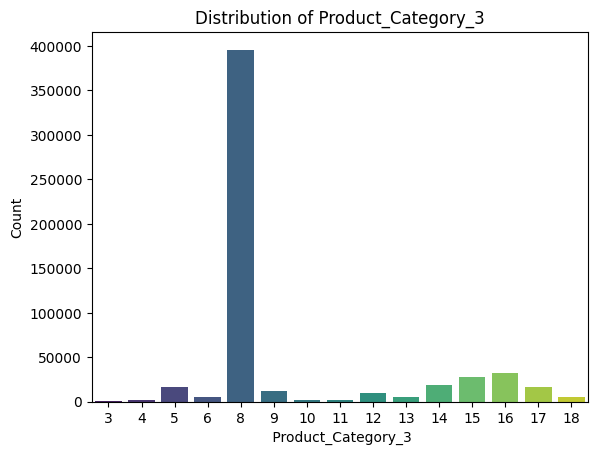

In [ ]:
sns.countplot(x='Product_Category_3', data=df, palette='viridis')
plt.title('Distribution of Product_Category_3')
plt.xlabel(' Product_Category_3')
plt.ylabel('Count')
plt.show()

# **Data Preprocessing**

In [ ]:
df1=df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547391 entries, 0 to 547390
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Gender                      547391 non-null  object
 1   Age                         547391 non-null  object
 2   Occupation                  547391 non-null  int64 
 3   City_Category               547391 non-null  object
 4   Stay_In_Current_City_Years  547391 non-null  object
 5   Marital_Status              547391 non-null  int64 
 6   Product_Category_1          547391 non-null  int64 
 7   Product_Category_2          547391 non-null  int64 
 8   Product_Category_3          547391 non-null  int64 
 9   Purchase                    547391 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 41.8+ MB





**One Hot Encoding**

In [ ]:
df= pd.get_dummies(df,columns=['Stay_In_Current_City_Years'])

In [ ]:
columns_to_convert = [
    'Stay_In_Current_City_Years_0',
    'Stay_In_Current_City_Years_1',
    'Stay_In_Current_City_Years_2',
    'Stay_In_Current_City_Years_3',
    'Stay_In_Current_City_Years_4+'
    ]

df[columns_to_convert] = df[columns_to_convert].astype(int)


In [ ]:
df.head()

,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,F,0-17,10,A,0,3,8,8,8370,0,0,1,0,0
1,F,0-17,10,A,0,1,6,14,15200,0,0,1,0,0
2,F,0-17,10,A,0,12,8,8,1422,0,0,1,0,0
3,F,0-17,10,A,0,12,14,8,1057,0,0,1,0,0
4,M,55+,16,C,0,8,8,8,7969,0,0,0,0,1


**Label Encoding**

In [ ]:
lst = df.select_dtypes(include='object')
lst

,Gender,Age,City_Category
0,F,0-17,A
1,F,0-17,A
2,F,0-17,A
3,F,0-17,A
4,M,55+,C
...,...,...,...
547386,M,51-55,B
547387,F,26-35,C
547388,F,26-35,B
547389,F,55+,C


In [ ]:
dict1={}
for i in lst:
  dict1[i]=LabelEncoder()
  df[i]=dict1[i].fit_transform(df[i])

In [ ]:
df.dtypes

,0
Gender,int64
Age,int64
Occupation,int64
City_Category,int64
Marital_Status,int64
Product_Category_1,int64
Product_Category_2,int64
Product_Category_3,int64
Purchase,int64
Stay_In_Current_City_Years_0,int64


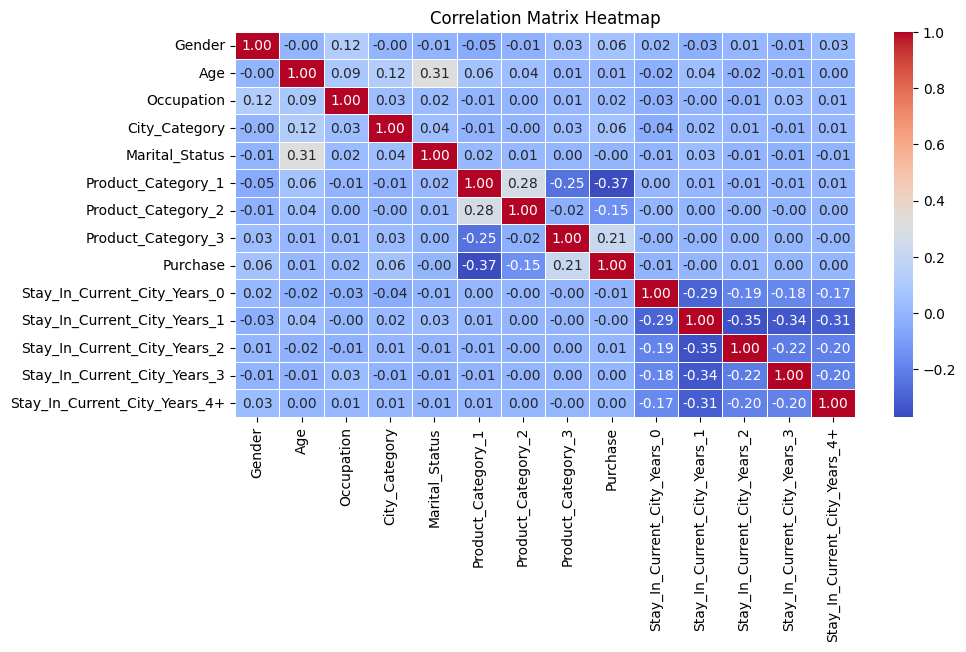

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=12)
plt.show()

# **Splitting data**

In [ ]:
x = df.drop("Purchase",axis=1)

In [ ]:
y=df['Purchase']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

# **Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
x_train_scaled=minmax.fit_transform(x_train)
x_test_scaled=minmax.transform(x_test)

# **Modeling**

**Polynomial Regression**

In [ ]:
#polynomial regression
poly=PolynomialFeatures(degree=3)
x_train_pol=poly.fit_transform(x_train_scaled)
x_test_pol=poly.transform(x_test_scaled)
model_pol=LinearRegression()
model_pol.fit(x_train_pol,y_train)
y_pred=model_pol.predict(x_test_pol)
print('MSE',mean_squared_error(y_test,y_pred))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE',mean_absolute_error(y_test,y_pred))
print('R2Score',r2_score(y_test,y_pred))

MSE 16311659.901778428
RMSE 4038.7696024629117
MAE 3018.797631806501
R2Score 0.32900738058063517


**L1 and L2 Regression**

In [ ]:
#Lasso model
lasso = Lasso(alpha=1.0)  # alpha is the regularization strength
lasso.fit(x_train_scaled, y_train)
y_pred_lasso = lasso.predict(x_test_scaled)
print("Lasso Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R2 Score:", r2_score(y_test, y_pred_lasso))

Lasso Regression Results:
MSE: 20470519.80519921
R2 Score: 0.15792949413633617


In [ ]:
# Ridge model
ridge = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge.fit(x_train_scaled, y_train)
y_pred_ridge = ridge.predict(x_test_scaled)
print("Ridge Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R2 Score:", r2_score(y_test, y_pred_ridge))

Ridge Regression Results:
MSE: 20470541.606069937
R2 Score: 0.15792859734082643


In [ ]:
models=[LinearRegression(),KNeighborsRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),XGBRegressor()]
for model in models:
  print(model)
  print('------------------')
  model.fit(x_train_scaled,y_train)
  y_pred=model.predict(x_test_scaled)
  print('MSE',mean_squared_error(y_test,y_pred))
  print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred)))
  print('MAE',mean_absolute_error(y_test,y_pred))
  print('R2Score',r2_score(y_test,y_pred))
  print("*******************************")

LinearRegression()
------------------
MSE 20470382.586062428
RMSE 4524.420690658908
MAE 3478.109305922615
R2Score 0.15793513875059229
*******************************
KNeighborsRegressor()
------------------
MSE 12384973.066742258
RMSE 3519.2290443706925
MAE 2581.110076849067
R2Score 0.49053465008882247
*******************************
RandomForestRegressor()
------------------
MSE 9150595.104752615
RMSE 3024.99505863276
MAE 2204.4527212432404
R2Score 0.6235832640236361
*******************************
GradientBoostingRegressor()
------------------
MSE 8794356.741044125
RMSE 2965.5280711947617
MAE 2252.270657580241
R2Score 0.6382374018760545
*******************************
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, impo

**Cross Validation**

In [ ]:
cross_val_score(XGBRegressor(),x_train_scaled,y_train,cv=5).mean()

0.6624734266740524

**Hyperparameter Tuning**

In [ ]:

parameters = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [i for i in range(3, 15)],
    'n_estimators': [i for i in range(50, 1001, 50)],
    'subsample': [0.6, 0.8, 1.0],  # Added subsample to explore different sampling rates
    'colsample_bytree': [0.6, 0.8, 1.0],  # Added colsample_bytree to control feature sampling
}
rs_cv=RandomizedSearchCV(XGBRegressor(),parameters,cv=5,n_iter=4)
rs_cv.fit(x_train_scaled,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                                                         900, 950, 1000],
                                        'subsample': [0.6, 0.8, 1.0]})

In [ ]:
rs_cv.best_score_

0.6632705371640046

# **Final Model**

In [ ]:
tuned_model=rs_cv.best_estimator_
y_pred=tuned_model.predict(x_test_scaled)

In [ ]:
print('MSE',mean_squared_error(y_test,y_pred))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE',mean_absolute_error(y_test,y_pred))
print('R2Score',r2_score(y_test,y_pred))

MSE 8146361.882536122
RMSE 2854.183225116447
MAE 2126.5688598876022
R2Score 0.6648931665314444
